<div align='center'>
    <h1>Sequence-to-Sequence Learning – Neural Machine Translation</h1>
</div>

- **Sequence-to-sequence learning** is the term used for tasks that require mapping an arbitrary-length sequence to another arbitrary-length sequence. 

- This is one of the most sophisticated tasks in NLP, which involves learning many-to-many mappings. 

- Examples of this task include **Neural Machine Translation (NMT)** and creating **chatbots**. NMT is where we translate a sentence from one language (source language) to another (target language) like Google Translate.

## Understanding Neural Machine Translation

### Intuition behind NMT systems

Let’s understand the intuition underlying an NMT system’s design. 

- For translating a sentence from English to German, say: `I went home --> Ich ging nach Hause`. The way we translate this is:
    - First, you read the English sentence, and then you create a thought or concept about what this sentence represents or implies, in your mind. And finally, you translate the sentence into German.<br></br>
    
- The same idea is used for building NMT systems. 
    - The **encoder** reads the source sentence (that is, similar to you reading the English sentence). 
    
    - Then the encoder outputs a **context vector** (the context vector corresponds to the thought/concept you imagined after reading the sentence). 
    
    - Finally, the **decoder** takes in the context vectors and outputs the translation in German:
    
<div align='center'>
    <img src='images/nmt_system.png'/>
</div>

### NMT Architecture

- NMT is a encoder-decoder architecture. 

- The **encoder** converts a sentence from a given source language into a thought vector (i.e. a contextualized representation), and the **decoder** decodes or translates the thought into a target language.

- The left-hand side of the context vector denotes the encoder (which takes a source sentence in word by word to train a time-series model). 

- The right-hand side denotes the decoder, which outputs word by word (while using the previous word as the current input) the corresponding translation of the source sentence. 

- We will also use embedding layers (for both the source and target languages) where the semantics of the individual tokens will be learned and fed as inputs to the models:

<div align='center'>
    <img src='images/nmt_system1.png'/>
</div>

* **

The objective of the NMT is to maximize the log-likelihood, given a source sentence $x_s$ and its corresponding translation $y_T$ : $$\frac{1}{N} \sum_{i = 1}^{N} \log P(y_T | x_s)$$ Here, $N$ refers to the number of source and target sentence inputs we have as training data.

Then, during inference, for a given source sentence, $x_s^{infer}$, we will find the $Y_T^{best}$ translation as:

$$Y_T^{best} = {argmax}_{y\in Y_T} P(y_T | x_s^{infer})$$

* **

Let's connect the dots b/w the embedding layer, the encoder, the context vector, and the decoder:

1. We use two word embedding layers, one for the source language and the other for the target, to better represent the semantics b/w the words of the respective languages.

2. The encoder is responsible for generating a thought vector or a context vector that represents what is meant by the source language.
    - The encoder is an RNN cell.
    
    - At time step $t_0$ the enocoder is initialized with a zero vector by default. After finally getting trained on the sequence of source sentences/words, It produces a context vector which is it's final external hidden state.<br></br>
    
3. The idea of the context vector is to represent a sentence of a source language concisely.
    - Also, in contrast to how the encoder’s state is initialized (that is, it is initialized with zeros), the context vector becomes the initial state for the decoder.
    
    - This creates a linkage between the encoder and the decoder and makes the whole model end-to-end differentiable. <br></br>
    
4. The decoder is responsible for decoding the context vector into the desired translation. Our decoder is an RNN as well.
    - The context vector is the only piece of information that is available to the decoder about the source sentence. Thus, it is a crucial link b/w encoder and decoder.
    
    - After getting initialized with the context vector as it's initial state the decoder then learns the patterns in the target text.
    
    - Though it is possible for the encoder and decoder to share the same set of weights, it is usually better to use two different networks for the encoder and the decoder. This increases the number of parameters in our model, allowing us to learn the translations more effectively.
    
    - For the prediction we use something like softmax function to predict the words.
    
    
The full NMT system with the details of how the GRU cell in the encoder connects to the GRU cell in the decoder, and how the softmax layer is used to output predictions, is shown:

<div align='center'>
    <img src='images/nmt_gru.png'/>
</div>

# Neural Machine Translation: English to German

In [1]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import time
import json

def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")
 
# Set the random seed
random_seed=4321
fix_random_seed(random_seed)

print(f"TensorFlow version: {tf.__version__}")

print(f"Tensorflow GPU Access status: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.10.1
Tensorflow GPU Access status: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## The Data

WMT-14 English-German translation data from https://nlp.stanford.edu/projects/nmt/. There are ~4.5 million sentence pairs available. However, we will use only 250,000 sentence pairs due to computational feasibility.

The required files are:
- File containing German sentences: `train.de`
- File containing English sentences: `train.en`
- File containing German vocabulary: `vocab.50K.de`
- File containing English vocabulary: `vocab.50K.en`

### Reading the dataset

In [2]:
n_sentences = 250000

# Loading English sentences
original_en_sentences = []
with open('data/train.en', 'r', encoding='utf-8') as en_file:
    for i,row in enumerate(en_file):
        # if i < 50: continue # or i==22183 or i==27781 or i==81827: continue
        if i >= n_sentences: break
        original_en_sentences.append(row.strip().split(" "))
        
# Loading German sentences
original_de_sentences = []
with open('data/train.de', 'r', encoding='utf-8') as de_file:
    for i, row in enumerate(de_file):
        # if i < 50: continue # or i==22183 or i==27781 or i==81827: continue
        if i >= n_sentences: break
        original_de_sentences.append(row.strip().split(" "))

In [3]:
len(original_en_sentences), len(original_de_sentences)

(250000, 250000)

In [4]:
# Print a few sentences
for en_s, de_s in zip(original_en_sentences[:10], original_de_sentences[:10]):
    print(f"English: {' '.join(en_s)}\nGerman: {' '.join(de_s)}\n")

English: iron cement is a ready for use paste which is laid as a fillet by putty knife or finger in the mould edges ( corners ) of the steel ingot mould .
German: iron cement ist eine gebrauchs ##AT##-##AT## fertige Paste , die mit einem Spachtel oder den Fingern als Hohlkehle in die Formecken ( Winkel ) der Stahlguss -Kokille aufgetragen wird .

English: iron cement protects the ingot against the hot , abrasive steel casting process .
German: Nach der Aushärtung schützt iron cement die Kokille gegen den heissen , abrasiven Stahlguss .

English: a fire restant repair cement for fire places , ovens , open fireplaces etc .
German: feuerfester Reparaturkitt für Feuerungsanlagen , Öfen , offene Feuerstellen etc.

English: Construction and repair of highways and ...
German: Der Bau und die Reparatur der Autostraßen ...

English: An announcement must be commercial character .
German: die Mitteilungen sollen den geschäftlichen kommerziellen Charakter tragen .

English: Goods and services adva

### Adding special tokens

We add special tokens `<s>` and `</s>` to denote the beginning and end of sequences respectively.

- **This is a very important step for Seq2Seq models. `<s>` and `</s>` tokens serve an extremely important role during model inference.** 

- At inference time, we will be using the decoder to predict one word at a time, by using the output of the previous time step as an input. This way we can predict for an arbitrary number of time steps. 

- Using `<s>` as the starting token gives us a way to signal to the decoder that it should start predicting tokens from the target language. 

- Next, if we do not use the `</s>` token to mark the end of a sentence, we cannot signal the decoder to end a sentence. This can lead the model to enter an infinite loop of predictions.

In [5]:
en_sentences = [["<s>"]+sent+["</s>"] for sent in original_en_sentences]
de_sentences = [["<s>"]+sent+["</s>"] for sent in original_de_sentences]

In [6]:
# Print a few sentences
for en_s, de_s in zip(en_sentences[:5], de_sentences[:5]):
    print(f"English: {' '.join(en_s)}\nGerman: {' '.join(de_s)}\n")

English: <s> iron cement is a ready for use paste which is laid as a fillet by putty knife or finger in the mould edges ( corners ) of the steel ingot mould . </s>
German: <s> iron cement ist eine gebrauchs ##AT##-##AT## fertige Paste , die mit einem Spachtel oder den Fingern als Hohlkehle in die Formecken ( Winkel ) der Stahlguss -Kokille aufgetragen wird . </s>

English: <s> iron cement protects the ingot against the hot , abrasive steel casting process . </s>
German: <s> Nach der Aushärtung schützt iron cement die Kokille gegen den heissen , abrasiven Stahlguss . </s>

English: <s> a fire restant repair cement for fire places , ovens , open fireplaces etc . </s>
German: <s> feuerfester Reparaturkitt für Feuerungsanlagen , Öfen , offene Feuerstellen etc. </s>

English: <s> Construction and repair of highways and ... </s>
German: <s> Der Bau und die Reparatur der Autostraßen ... </s>

English: <s> An announcement must be commercial character . </s>
German: <s> die Mitteilungen sollen 

## Train, validation and test split

Here we split the full dataset as follows:
- Train - 80%
- Validation - 10%
- Test - 10%

In [7]:
from sklearn.model_selection import train_test_split

train_en_sentences, valid_test_en_sentences, train_de_sentences, valid_test_de_sentences = train_test_split(
    np.array(en_sentences, dtype=object), np.array(de_sentences, dtype=object), test_size=0.2
)

valid_en_sentences, test_en_sentences, valid_de_sentences, test_de_sentences = train_test_split(
    valid_test_en_sentences, valid_test_de_sentences, test_size=0.5)

print(f"Train size: {len(train_en_sentences)}")
print(f"Valid size: {len(valid_en_sentences)}")
print(f"Test size: {len(test_en_sentences)}")

Train size: 200000
Valid size: 25000
Test size: 25000


## Analyse lengths of sequences

A key statistic we have to understand at this point is how long, generally, the sentences in our corpus are. It is quite likely that the two languages will have different sentence lengths.


- Here we can see that 95% of English sentences have 54 tokens, where 95% of German sentences have 49 tokens

- We use the 80% percentile of the sequence lengths for each language as a threshold to,
    - Truncate sequences longer than that
    - Add a special token (`<pad>`) to bring shorter sentences to that length

>Note that we are only using the training data for this calculation. If you include validation or test datasets in these calculations, we may be leaking data about validation and test data. Therefore, it’s best to only use the training dataset for these calculations.

In [8]:
print("Sequence lengths (English)")
print(pd.Series(train_en_sentences).str.len().describe(percentiles=[0.05,0.5,0.8,0.9,0.95]))

print("\nSequence lengths (German)")
print(pd.Series(train_de_sentences).str.len().describe(percentiles=[0.05,0.5,0.8,0.9,0.95]))

Sequence lengths (English)
count    200000.000000
mean         26.864400
std          13.587173
min           8.000000
5%           11.000000
50%          24.000000
80%          36.000000
90%          45.000000
95%          54.000000
max         102.000000
dtype: float64

Sequence lengths (German)
count    200000.000000
mean         24.757705
std          12.426796
min           8.000000
5%           11.000000
50%          22.000000
80%          33.000000
90%          41.000000
95%          49.000000
max         102.000000
dtype: float64


## Padding the sentences to a fixed length

In [9]:
n_en_seq_length = 36
n_de_seq_length = 33

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

pad_token = '<pad>'

train_en_sentences_padded = pad_sequences(train_en_sentences, maxlen=n_en_seq_length,
                                          value=pad_token, dtype=object, truncating='post',
                                          padding='post')

valid_en_sentences_padded = pad_sequences(valid_en_sentences, maxlen=n_en_seq_length,
                                          value=pad_token, dtype=object, truncating='post',
                                          padding='post')

test_en_sentences_padded = pad_sequences(test_en_sentences, maxlen=n_en_seq_length,
                                         value=pad_token, dtype=object, truncating='post',
                                         padding='post')


train_de_sentences_padded = pad_sequences(train_de_sentences, maxlen=n_de_seq_length,
                                          value=pad_token, dtype=object, truncating='post',
                                          padding='post')

valid_de_sentences_padded = pad_sequences(valid_de_sentences, maxlen=n_de_seq_length,
                                          value=pad_token, dtype=object, truncating='post',
                                          padding='post')

test_de_sentences_padded = pad_sequences(test_de_sentences, maxlen=n_de_seq_length,
                                         value=pad_token, dtype=object, truncating='post',
                                         padding='post')

In [11]:
print("Some validation sentences ...\n")
for en_sent, de_sent in zip(valid_en_sentences_padded[:3], valid_de_sentences_padded[:3]):
    en_sent_str = ' '.join(en_sent)
    de_sent_str = ' '.join(de_sent)
    print(f"English: {en_sent_str}\nGermen: {de_sent_str}\n")

print("*"*50)
print("Some test sentences ...\n")
for en_sent, de_sent in zip(test_en_sentences_padded[:3], test_de_sentences_padded[:3]):
    en_sent_str = ' '.join(en_sent)
    de_sent_str = ' '.join(de_sent)
    print(f"English: {en_sent_str}\nGermen: {de_sent_str}\n")

Some validation sentences ...

English: <s> For DVDs and Videos , delivery charges and handling fees are already included in the price . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Germen: <s> In den Preisangaben für DVDs und Videos sind die Versandkosten und Bearbeitungsgebühren bereits enthalten . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

English: <s> So configure the \ xampp \ apache \ bin \ php.ini for web changes . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Germen: <s> Das ist zwar auch nicht ganz falsch , sollte PHP als Konsolenprogramm ( cli ) benutzt werden . In der Regel aber wird PHP im XAMPP über den Apache Webserver via mod

English: <s> Modern , elegant and equipped well , this excellent residence of the news hotel is a fantastic base of the festivities . </s> <pad> <pad> <pad>

* **
<div align='center'>
    <h3>Preprocessing Trick: Reversing the source sentence</h3>
</div>

We can also perform a special trick on the source sentences. Say we have the sentence
**ABC** in the source language, which we want to translate to $\alpha \beta \gamma \phi$  in the target language. 

We will first reverse the source sentences so that the sentence ABC is read as CBA. This means that in order to translate **ABC** to $\alpha \beta \gamma \phi$, we need to feed in **CBA**.

- This improves the performance of our model significantly, especially **when the source and target languages share the same sentence structure (for example, subject-verb-object).**

- Let’s try to understand why this helps. Mainly, it helps to build good communication between the encoder and the decoder. Let’s start from the previous example. We will concatenate the source and target sentences: $$ABC\alpha \beta \gamma$$

- If you calculate the distance (that is, the number of words separating two words)
from A to $\alpha$ or B to $\beta$, they will be the same. However, consider this when you reverse the source sentence, as shown here: $$CBA\alpha \beta \gamma$$


- Here, A is very close to $\alpha$ and so on. Also, to build good translations, building good communications at the very start is important. This simple trick can possibly help NMT systems to improve their performance.

>**Note:** that the source sentence reversing step is a subjective preprocessing step. This might not be necessary for some translational tasks. 

- For example, if your translation task is to translate from Japanese (which is often written in *subject-object-verb* format) to Filipino (often written *verb-subject-object*), then reversing the source sentence might actually cause harm rather than helping. This is because by reversing the text in Japanese, you are increasing the distance between the starting element of the target sentence (that is, the verb (Japanese)) and the corresponding source language entity (that is, the verb (Filipino)).
* **

## Loading Vocabulary 

Let's build the vocabulary dictionaries for both the source (German) and target (English) languages

Originally, each vocabulary contains 50,000 tokens. However, we’ll take only half of this to reduce the memory requirement. 

> **Note:** that we allow one extra token as there’s a special token `<unk>` to denote **out-of-vocabulary (OOV)** words. 
    
With a 50,000-token vocabulary, it is quite easy to run out of memory due to the size of the final prediction layer we’ll build. 

- **While cutting back on the size of the vocabulary, we have to make sure that we preserve the most common 25,000 words:**
    - Fortunately, each vocabulary file is organized such that words are ordered by their frequency of occurrence (high to low). Therefore, we just need to read the first 25,001 lines of text from the file:

In [12]:
# +1 for to denote out-of-vocabulary (OOV) words as <unk>.
n_vocab = 25000 + 1

en_vocabulary = []
with open('data/vocab.50K.en', 'r', encoding='utf-8') as en_file:
    for ri, row in enumerate(en_file):
        if ri  >= n_vocab: break
            
        en_vocabulary.append(row.strip())
        

de_vocabulary = []
with open('data/vocab.50K.de', 'r', encoding='utf-8') as de_file:
    for ri, row in enumerate(de_file):
        if ri >= n_vocab: break
            
        de_vocabulary.append(row.strip())
        

# Each of the vocabularies contain the special OOV token <unk> as the first line. 
# We pop out that, from the en_vocabulary and de_vocabulary lists as we need this 
# for the next step:
en_unk_token = en_vocabulary.pop(0)
de_unk_token = de_vocabulary.pop(0)

print(en_unk_token, de_unk_token)

<unk> <unk>


## String lookup layer: Converting tokens to IDs

Here we define a `StringLookup` layer for each language, which will convert string tokens to numerical IDs.

- After getting the vocabulary of our text data, **we have one more text processing operation remaining, that is, converting the processed text tokens into numerical IDs.** 

- We are going to use a `tf.keras.layers.StringLookup` to create a layer in our model that converts each token into a numerical ID. 

In [13]:
en_lookup_layer = tf.keras.layers.StringLookup(vocabulary=en_vocabulary, oov_token=en_unk_token,
                                               mask_token=pad_token, pad_to_max_tokens=False)

de_lookup_layer = tf.keras.layers.StringLookup(vocabulary=de_vocabulary, oov_token=de_unk_token,
                                               mask_token=pad_token, pad_to_max_tokens=False)

Let’s understand the arguments provided to this layer:
- `vocabulary` – Contains a list of words that are found in the corpus (except certain special tokens that will be discussed below)

- `oov_token` – A special out-of-vocabulary token that will be used to replace tokens not listed in the vocabulary

- `mask_token` – A special token that will be used to mask inputs (e.g. uninformative padded tokens)

- `pad_to_max_tokens` – If padding should occur to bring arbitrary-length sequences in a batch of data to the same length

In [14]:
wid_sample = en_lookup_layer(
    "iron cement protects the ingot against the hot , abrasive steel casting process .".split(" ")
)
print(f"Word IDs: {wid_sample}")
print(f"Sample vocabulary: {en_lookup_layer.get_vocabulary()[:15]}")

Word IDs: [ 4304 10519  6386     4     1   179     4  1840     5 19429  2315  7705
   224     6]
Sample vocabulary: ['<pad>', '<unk>', '<s>', '</s>', 'the', ',', '.', 'of', 'and', 'to', 'in', 'a', 'is', 'that', 'for']


In [15]:
en_lookup_layer(['iron', '<pad>', '<unk>'])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([4304,    0,    1], dtype=int64)>

<div align='center'>
    <h2><b>Defining the Model</b></h2>
</div>


Here we define the model. We'll be focusing on the following primary components.

1. **Encoder** - Convert an English token sequence to a context vect

2. **Decoder** - Consumes the context vector and generate predictions

3. **Decoder Attention** - Allows the decoder to look at any encoder state in order to learn about the source sentence

## Defining the Encoder

In [16]:
from tensorflow.keras import layers
import tensorflow.keras.backend as K
K.clear_session()

# Defining the encoder layers
encoder_input = layers.Input(shape=(n_en_seq_length,), dtype=tf.string)
# Converting tokens to IDs
encoder_wid_out = en_lookup_layer(encoder_input) # wid here means word_id

# Embedding layer and lookup
en_full_vocab_size = len(en_lookup_layer.get_vocabulary())
encoder_emb_out = layers.Embedding(en_full_vocab_size, 128, mask_zero=True)(encoder_wid_out)

# Encoder GRU layer
encoder_gru_out, encoder_gru_last_state = layers.GRU(256, return_sequences=True, return_state=True)(encoder_emb_out)

# Defining the encoder model: in - encoder_input / out - output of the GRU layer
encoder = tf.keras.models.Model(inputs=encoder_input, outputs=encoder_gru_out)

<div align='center'>
    <h3>Explanation of the Encoder model</h3>
</div>

1. We start the encoder with an input layer. The input layer will take in a batch of sequences of tokens. Each sequence of tokens  is `n_en_seq_length` elements long. Remember that we padded or truncated the sentences to make sure all of them have a fixed length of `n_en_seq_length`:
```
# Defining the encoder layers
encoder_input = layers.Input(shape=(n_en_seq_length,), dtype=tf.string)
```

2. Next we use the previously defined `StringLookup` layer to convert the string tokens into word IDs. As we saw, the `StringLookup` layer can take a list of unique words (i.e. a vocabulary) and create a lookup operation to convert a given token into a numerical ID:
```
# Converting tokens to IDs
encoder_wid_out = en_lookup_layer(encoder_input)
```

3. With the tokens converted into IDs, we route the generated word IDs to a token embedding layer. We pass in the size of the vocabulary (derived from the en_lookup_layer's `get_vocabulary()` method) and the embedding size (128) and finally we ask the layer to mask any zero-valued inputs as they don’t contain any information: 
```
# Embedding layer and lookup
en_full_vocab_size = len(en_lookup_layer.get_vocabulary())
encoder_emb_out = layers.Embedding(en_full_vocab_size, 128, 
                                   mask_zero=True)(encoder_wid_out)
```

4. The output of the embedding layer is stored in encoder_emb_out. Next we define a GRU layer to process the sequence of English token embeddings:

    - Note how we are setting both the `return_sequences` and `return_state` arguments to `True`. 

    - To recap, `return_sequences` returns the full sequence of hidden states as the output (instead of returning only the last), where `return_state` returns the last state of the model as an additional output. 

    - We need both these outputs to build the rest of our model. For example, we need to pass the last state of the encoder to the decoder as the initial state. For that, we need the last state of the encoder (stored in `encoder_gru_last_state`). 
    
```
# Encoder GRU layer
encoder_gru_out, enocder_gru_last_state = layers.GRU(256, return_sequences=True, 
                                             return_state=True)(encoder_emb_out)
```


5. We now have everything to define the encoder part of our model. It takes in a batch of sequences of string tokens and returns the full sequence of GRU hidden states as the output:
```
# Defining the encoder model: in - encoder_input / out - output of the GRU layer
encoder = tf.keras.models.Model(inputs=encoder_input, outputs=encoder_gru_out)
```

## Defining the decoder

Our decoder will be more complex than the encoder. **The objective of the decoder is, given the last encoder state and the previous token the decoder predicted, predict the next token.** 

For example, for the German sentence: `<s> ich ging zum Laden </s>` --> `i went to the store`

We define:

|  |  |  |  |  |  |
| ----- | --- | ---- | ---- | --- | ----- |
| **Input** | `<s>` | ich | ging | zum | Laden |
| **Output** | ich | ging | zum | Laden | `</s>` |

This technique is known as **teacher forcing**. In other words, the decoder is leveraging previous tokens of the target itself to predict the next token. This makes the translation task easier for the model.

* **

Training model architecture (Note that we're using GRU cells instead of LSTMs as shown in the image)

<div align='center'>
    <img src='images/model_arc.png'/>
</div>

To feed in previous tokens predicted by the decoder, we need an input layer for the decoder.

|  |  |  |  |  |  | |
| ----- | --- | ---- | ---- | --- | ----- | --- |
| **Input** | `<s>` | ich | ging | zum | Laden |---> i/p length is $n-1$ |
| **Output** | ich | ging | zum | Laden | `</s>` |---> o/p length is $n-1$  |

`<s> ich ging zum Laden </s>` ---> Actual length is $n$

Like we saw in this table, When formulating the decoder inputs and outputs this way, for a sequence of tokens with length $n$, the input and output are $n-1$ tokens long. Thus in the decoder i/p layer we passed the `shape=(n_de_seq_length-1,)`:
```
# Defining the decoder layers 
decoder_input = layers.Input(shape=(n_de_seq_length-1,), dtype=tf.string)
```

In [17]:
# Defining the decoder layers 
decoder_input = layers.Input(shape=(n_de_seq_length-1,), dtype=tf.string)
# Converting tokens to IDs (Decoder)
decoder_wid_out = de_lookup_layer(decoder_input) # wid here means word_id

# Embedding layer and lookup (decoder)
de_full_vocab_size = len(de_lookup_layer.get_vocabulary())
decoder_emb_out = layers.Embedding(de_full_vocab_size, 128, mask_zero=True)(decoder_wid_out)

# Decoder GRU layer
decoder_gru_out = layers.GRU(256, return_sequences=True)(decoder_emb_out, 
                                                         initial_state=encoder_gru_last_state)

# Note that we are passing the encoder’s last state to a special argument called 
# initial_state in the GRU’s call() method. This ensures that the decoder uses the 
# encoder's last state to initialize its memory.

## Attention: Analyzing the encoder states

- The next step of our journey takes us to one of the most important concepts in machine learning, **'attention'**. 

- *So far, the decoder had to rely on the encoder's last state as the 'only' input/signal about the source language. This is like asking to summarize a sentence using a single word. Generally, when doing so, you lose a lot of the meaning and message in this conversion.* 

- **Attention** alleviates this problem.


***Instead of relying just on the encoder's last state, attention enables the decoder to analyze the complete history of state outputs. The decoder does this at every step of the prediction and creates a weighted average of all the state outputs depending on what it needs to produce at that step.***

*For example, in the translation `I went to the shop -> ich ging zum Laden`, when predicting the word `ging`, the decoder will pay more attention to the first part of the English sentence than the latter.*

### $\large{\rightarrow}$ The context/thought vector is a performance bottleneck

As we have seen in the encoder-decoder architecture of NMT, that the encoder part spits out a summazied representation of the source language sentence as *'context/thought vector'*, which basically creates a link b/w the encoder and the decoder; which later the decoder uses to translate the sentence.

<div align='center'>
    <img src='images/enc_dec.png'/>
</div>

- ***To understand why the context/thought vector is a performance bottleneck***,

    - Let's imagine translating the foll. English sentence: $$\text{I went to the flower market to buy some flowers}$$

    - This translates to the following: $$\text{Ich ging zum Blumenmarkt, um Blumen zu kaufen}$$ 

- If we are to compress this into a fixed-length vector, the resulting vector needs to contain these:
    - *Information about the subject (I)*
    - *Information about the verbs (buy and went)*
    - *Information about the objects (flowers and flower market)*
    - *Interaction of the subjects, verbs, and objects with each other in the sentence*<br></br>


- *Generally, the context vector has a size of 128 or 256 elements.* Reliance on the context vector to store all this information with a small-sized vector is very impractical and an extremely difficult requirement for the system. 

- *Therefore, most of the time, the context vector fails to provide the complete information required to make a good translation.*

- **This results in an underperforming decoder that suboptimally translates a sentence.**


- *To make the problem worse, during decoding the context vector is observed only in the beginning. Thereafter, the decoder GRU must memorize the context vector until the end of the translation. This becomes more and more difficult for long sentences.*

### $\large{\rightarrow}$ How **Attention** deals with this issue?

<div align='center'>
    <h4>Attention sidesteps this issue:</h4>
</div>


1. **With attention, the decoder will have access to the full state history of the encoder for each decoding time step.** 
    - *This allows the decoder to access a very rich representation of the source sentence.*<br></br> 

2. Furthermore, the attention mechanism introduces a `softmax` layer **that allows the decoder to calculate a weighted mean of the past observed encoder states, which will be used as the context vector for the decoder.** 
    - *This allows the decoder to pay different amounts of attention to different words at different decoding steps.*<br></br>
    
    
<div align='center'>
    <h4>Conceptual breakdown of the Attention Mechanism</h4>
    <img src='images/att_mech_nmt.png'/>
</div>

## **The Bahdanau Attention Mechanism**

Also called ***Additive Attention***

### *Computing Attention:*

- [The Bahdanau Attention Mechanism - ML Mastery](https://machinelearningmastery.com/the-bahdanau-attention-mechanism/)
- [The Bahdanau Attention Mechanism - dl.ai](https://d2l.ai/chapter_attention-mechanisms-and-transformers/bahdanau-attention.html)

The Bahdanau attention mechanism introduced in the paper [Neural Machine Translation by Learning to Jointly Align and Translate](https://arxiv.org/abs/1409.0473), by [Dzmitry Bahdanau](https://rizar.github.io/).

**We'll implement a slightly different version of it, due to the limitations of TensorFlow.** 

Some notations:
- Encoder's $j^{th}$ hidden state: $h_j$
- $i^{th}$ target token: $y_i$
- $i^{th}$ decode hidden state in the $i^{th}$ time step: $s_i$
- Context Vector: $c_i$

* **

- Our **decoder GRU** is a function of an input $y_i$ and a previous step's hidden state $s_{i-1}$. This can be represented as follows: $${GRU}_{dec} = \mathcal{f}(y_i, s_{i-1})$$ 

    - Here, $\mathcal{f}$ represents the actual update rules used to calculate $y_i$ and $s_{i-1}$.<br></br>
    
- *With the attention mechanism, we are introducing a new time-dependent context vector $c_i$ for the $i^{th}$ decoding step:* 

    - **The $c_i$ vector is a weighted mean of the hidden states of all the unrolled encoder steps.**

    - A higher weight will be given to the $j^{th}$ hidden state of the encoder if the $j^{th}$ word is more important for translating the $i^{th}$ word in the target language. 

    - This means the model can learn which words are important at which time step, regardless of the directionality of the two languages or alignment mismatches.<br></br>

- Now the decoder GRU becomes this: $${GRU}_{dec} = \mathcal{f}(y_i, s_{i-1}, c_i)$$ 


* **

- Conceptually, the attention mechanism can be thought of as a separate layer and as illustrated. As shown, **attention functions as a layer**. 

- The attention layer is responsible for producing the context vector $c_i$ for the $i^{th}$ time step of the decoding process. $c_i$ is calculated as: $$c_i = \sum_{j=1}^{L}\alpha_{ij}h_j$$

    - Here, $L$ is the number of words in the source sentence, and 
    
    - $\alpha_{ij}$ is a normalized weight representing the importance of the $j^{th}$ encoder hidden state for calculating the $i^{th}$ decoder prediction.<br></br>
    

- $\alpha_{ij}$ is calculated using something called **energy value**.
    - We represent $e_{ij}$ as the energy of the encoder’s $j^{th}$ position for predicting the decoder’s $i^{th}$ position. 
    
    - $e_{ij}$ is computed using a small fully connected network as follows: $$e_{ij} = \nu_{a}^{T} \tanh(W_a s_{i-1} + U_a h_j)$$ 
    
    - In other words, $e_{ij}$ is calculated with a multilayer perceptron whose weights are $\nu_{a}$, $W_a$, and $U_a$ ; and<br></br> $s_{i-1}$ (decoder’s previous hidden state from $(i-1)^{th}$ time step) and $h_j$ (encoder’s $j^{th}$ hidden output) are the inputs to this network.<br></br>
    
-  Finally, we compute the normalized energy values (i.e. weights) using softmax normalization over all encoder timesteps: $$\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k=1}^{L} \exp({e_{ik}})}$$ <br></br>




<div align='center'>
    <h4>The Attention Mechanism</h4>
    <img src='images/bahdanau_attention.png'/>
</div>



### $\large{\rightarrow}$ *Simple & Intuitive Explanation of Bahdanau Attention*

Credit: ChatGPT

- **The Bahdanau Attention Mechanism, also known as Additive Attention**, is like a spotlight that helps a machine learning model focus on the most relevant parts of a long piece of information when making decisions, just like how you pay attention to different words when reading a sentence.

Here's a simple and intuitive explanation:

- Imagine you're translating a sentence from one language to another, and the sentence is quite long. Bahdanau Attention is like having a little assistant who highlights specific words in the original sentence for you as you translate.

    1. **The Sentence**: Let's say you have a long sentence in a foreign language you want to translate, like "The big blue car drove quickly down the winding mountain road."

    2. **The Assistant**: Your Bahdanau Attention assistant looks at each word in the sentence and decides which words are the most important for you to pay attention to while translating.

    3. **Highlighting**: It highlights certain words, like "big," "blue," and "car," which are the key pieces of information for understanding the sentence.

    4. **Translating**: As you translate, you focus more on the highlighted words, so you might say something like, "The important thing here is that there's a big blue car." You give extra importance to those highlighted words because they carry the crucial details.

    5. **Dynamic Attention**: What's cool is that the assistant can change its highlights for different sentences. If the next sentence is, "The small red bicycle went slowly up the steep hill," it will highlight different words like "small," "red," and "bicycle."

In summary, Bahdanau Attention is like having a helpful spotlight that guides you through understanding and translating sentences by emphasizing the important words. It's a way for machines to focus on the relevant parts of information when processing sequences of data, making them more efficient and accurate in tasks like translation, summarization, and more.

## *Implementing Attention*

- **As stated above we’ll implement a slightly different variation of Bahdanau attention.**
    - *In the traditional Bahdanau attention mechanism, which is commonly used in sequence-to-sequence models, the attention scores are computed at each time step(time-dependent context vector) within the RNN model. These scores are then used to weigh the importance of different parts of the input sequence when making predictions.*
    
    - *TensorFlow currently does not support an attention mechanism that can be iteratively computed for each time step, similar to how an RNN works.*<br></br>

- **Therefore, we are going to decouple the attention mechanism from the GRU model and have it computed separately.** 

    - *We will concatenate the attention output with the hidden output of the GRU layer and feed it to the final prediction layer. In other words, we are not feeding attention output to the GRU model, but directly to the prediction layer as illustrated below:*


<div align='center'>
    <img src='images/att_mech_implemented.png'/>
</div>

* **

To implement attention, we define a class called `BahdanauAttention` (which inherits from the `tf.keras.layers.Layer` class) and override two functions in that:
- `__init__()` – Defines the layer's initialization logic
- `call()` – Defines the computational logic of the layer

In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        # Weights to compute Bahdanau attention
        self.Wa = tf.keras.layers.Dense(units, use_bias=False)
        self.Ua = tf.keras.layers.Dense(units, use_bias=False)
        
        # Additive attention layer, a.k.a. Bahdanau-style attention
        self.attention = tf.keras.layers.AdditiveAttention(use_scale=True)
        
    def call(self, query, key, value, mask, return_attention_scores=False):
        
        # Compute Wa.ht
        wa_query = self.Wa(query)
        
        # Compute Ua.ht
        ua_key = self.Ua(key)
        
        # Compute masks
        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask
        
        # Compute the attention
        context_vector, attention_weights = self.attention(inputs = [wa_query, value, ua_key],
                                                           mask = [query_mask, value_mask, value_mask],
                                                           return_attention_scores = True)
        
        if not return_attention_scores:
            return context_vector
        else:
            return context_vector, attention_weights

<h3 align='center'>Explanation of Bahdanau Attention Code</h3>

1. **the `__init__()` function:**
    1. Here we are defining 3 layers: `weight matrix W_a`, `weight matrix U_a`, and the `AdditiveAttention` layer, which contains the attention computation logic.
    
    2. The `AdditiveAttention` layer takes in a `query`, `value`, and a `key`.
        1. The `query` is the decoder states
        2. The `value` & `key` are all the encoder states produced
        
        
```
def __init__(self, units):
    super().__init__()
    # Weights to compute Bahdanau attention
    self.Wa = tf.keras.layers.Dense(units, use_bias=False)
    self.Ua = tf.keras.layers.Dense(units, use_bias=False)

    # Additive attention layer, a.k.a. Bahdanau-style attention
    self.attention = tf.keras.layers.AdditiveAttention(use_scale=True)
```

* **

2. **the `call()` function:**
    1. The first thing to note is that this func. takes in `query`, `key`, and `value` . These three elements will drive the attention computation. 
    
    2. *In Bahdanau attention, you can think of the `key` and `value` as being the same thing*.
    
    3. *The `query` will represent each decoder GRU's hidden states for each time step, and the `value (or key)` will represent each encoder GRU’s hidden states for each time step.*
    
    4. *In other words, we are querying an output for each decoder position based on values provided by the encoder’s hidden states.*
    
    
```
def call(self, query, key, value, mask, return_attention_scores=False):
    # Compute Wa.ht
    wa_query = self.Wa(query)

    # Compute Ua.ht
    ua_key = self.Ua(key)

    # Compute masks
    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    # Compute the attention
    context_vector, attention_weights = self.attention(
                        inputs = [wa_query, value, ua_key],
                        mask = [query_mask, value_mask, value_mask],
                        return_attention_scores = True
                        )

    if not return_attention_scores:
        return context_vector
    else:
        return context_vector, attention_weights
```

* **

3. Let's look at the computations we need to calculate as discussed in Computing Attention section:
    1. Calculate **energy value** : $$e_{ij} = \nu_{a}^{T} \tanh(W_a s_{i-1} + U_a h_j)$$ 
    
    2. Calculate normalized weights that represents the importance of encoder's hidden states while translating a sentence with the decoder : $$\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k=1}^{L} \exp({e_{ik}})}$$
    
    3. Calculate context vector which is a weighted mean of the hidden states of all the unrolled encoder steps : $$c_i = \sum_{j=1}^{L} \alpha_{ij} h_{j}$$
    
* **

4. First we compute `wa_query` (represents $W_{a}s_{i-1}$) and `ua_key` (represents $U_{a}h_{j}$), the we pass these values to the attention layer to perform the following steps:

    - As discussed in the [tensorflow doc.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention):
    
    - Inputs are `query` tensor of shape `[batch_size, Tq, dim]`, `value` tensor of shape `[batch_size, Tv, dim]` and `key` tensor of shape `[batch_size, Tv, dim]`. The calculation follows the steps:

        1. Reshapes `wa_query` from `[batch_size, Tq, dim]` to shape `[batch_size, Tq, 1, dim]` and `ua_key` from `[batch_size, Tv, dim]` shape to `[batch_size, 1, Tv, dim]`.

        2. Calculates `scores` with shape `[batch_size, Tq, Tv]` as: `scores = tf.reduce_sum(tf.tanh(query + key), axis=-1)`.

        3. Uses `scores` to calculate a `distribution` with shape `[batch_size, Tq, Tv]` using `softmax` activation: `distribution = tf.nn.softmax(scores)`.

        4. Uses `distribution` to create a linear combination of value with shape `[batch_size, Tq, dim]`.

        5. Returns `tf.matmul(distribution, value)`, which represents a weighted average of all encoder states (i.e. value).
        
        
- Here, you can see that `step B` performs the first equation, `step C` performs the second equation, and finally `step E` performs the third equation. 

- Another thing worth noting is that `step B` does not mention $\nu_a$ from the first equation. $\nu_a$ is essentially a weight matrix with which we compute the dot product. We can introduce this weight matrix by setting `use_scale=True` when defining the `AdditiveAttention` layer:

>`self.attention = tf.keras.layers.AdditiveAttention(use_scale=True)`


- Another important argument is the `return_attention_scores` argument when calling the `AdditiveAttention` layer. This gives us the distribution weight matrix defined in `step C`. We will use this to visualize where the model was paying attention when decoding the translation.

## Defining the final model

Continuing the implementation of **Decoder Attention**

In [19]:
# Adding Attention to the decoder
# The attention mechanism (inputs: [query, value, key])

# When defining attention, we also pass a mask that denotes which tokens 
# need to be ignored when computing outputs (e.g. padded tokens).

decoder_attn_out, attn_weights = BahdanauAttention(units=256)(
                                    query=decoder_gru_out, 
                                    key=encoder_gru_out, value=encoder_gru_out,
                                    mask=(encoder_wid_out != 0),
                                    return_attention_scores=True
                                 )

# Concatenate decoder GRU output and the attention output 
# to feed the prediction layer
context_and_rnn_output = layers.Concatenate(axis=-1)([decoder_attn_out, decoder_gru_out])

# Final Prediction layer
# de_full_vocab_size -> Size of the target language(German) vocab
decoder_out = layers.Dense(de_full_vocab_size, 
                           activation='softmax')(context_and_rnn_output)


# Now with the encoder and the decoder fully defined,
# Let's define final Seq2Seq Model
seq2seq_model = tf.keras.models.Model(inputs=[encoder.inputs, decoder_input],
                                      outputs=decoder_out)


# Compile the Seq2Seq model
seq2seq_model.compile(loss='sparse_categorical_crossentropy', 
                      optimizer='adam',
                      metrics='accuracy')

# seq2seq_model.summary()

### Secondary Model: `attention_visualizer`

We are also going to define a secondary model called the `attention_visualizer`.

- *The `attention_visualizer` can generate attention patterns for a given set of inputs. This is a handy way to know if the model is paying attention to the correct words during the decoding process. This visualizer model will be used once the full model is trained.*

In [20]:
attention_visualizer = tf.keras.models.Model(inputs=[encoder.inputs, decoder_input],
                                             outputs=[attn_weights, decoder_out])

## **Complete Code: Seq2Seq Model**

In [21]:
from tensorflow.keras import layers
import tensorflow.keras.backend as K
K.clear_session()

# Set random seed
tf.random.set_seed(42)

# -----------------------------------------------------------------------------------
# Defining the encoder layers
encoder_input = layers.Input(shape=(n_en_seq_length,), dtype=tf.string)
# Converting tokens to IDs
encoder_wid_out = en_lookup_layer(encoder_input) # wid here means word_id

# Embedding layer and lookup
en_full_vocab_size = len(en_lookup_layer.get_vocabulary())
encoder_emb_out = layers.Embedding(en_full_vocab_size, 128, mask_zero=True)(encoder_wid_out)

# Encoder GRU layer
encoder_gru_out, encoder_gru_last_state = layers.GRU(256, return_sequences=True, 
                                                     return_state=True)(encoder_emb_out)

# Defining the encoder model: in - encoder_input / out - output of the GRU layer
encoder = tf.keras.models.Model(inputs=encoder_input, outputs=encoder_gru_out)

# -----------------------------------------------------------------------------------

# Defining the decoder layers 
decoder_input = layers.Input(shape=(n_de_seq_length-1,), dtype=tf.string)
# Converting tokens to IDs (Decoder)
decoder_wid_out = de_lookup_layer(decoder_input) # wid here means word_id

# Embedding layer and lookup (decoder)
de_full_vocab_size = len(de_lookup_layer.get_vocabulary())
decoder_emb_out = layers.Embedding(de_full_vocab_size, 128, mask_zero=True)(decoder_wid_out)

# Decoder GRU layer
decoder_gru_out = layers.GRU(256, return_sequences=True)(decoder_emb_out, 
                                                         initial_state=encoder_gru_last_state)

# Note that we are passing the encoder’s last state to a special argument called 
# initial_state in the GRU’s call() method. This ensures that the decoder uses the 
# encoder's last state to initialize its memory.

# -----------------------------------------------------------------------------------

# Adding Attention to the decoder
# The attention mechanism (inputs: [query, value, key])

# When defining attention, we also pass a mask that denotes which tokens 
# need to be ignored when computing outputs (e.g. padded tokens).

decoder_attn_out, attn_weights = BahdanauAttention(units=256)(
                                    query=decoder_gru_out, 
                                    key=encoder_gru_out, value=encoder_gru_out,
                                    mask=(encoder_wid_out != 0),
                                    return_attention_scores=True
                                 )

# Concatenate decoder GRU output and the attention output 
# to feed the prediction layer
context_and_rnn_output = layers.Concatenate(axis=-1)([decoder_attn_out, decoder_gru_out])

# Final Prediction layer
# de_full_vocab_size -> Size of the target language(German) vocab
decoder_out = layers.Dense(de_full_vocab_size, 
                           activation='softmax')(context_and_rnn_output)


# Now with the encoder and the decoder fully defined,
# Let's define final Seq2Seq Model
seq2seq_model = tf.keras.models.Model(inputs=[encoder.inputs, decoder_input],
                                      outputs=decoder_out)


# Define a secondary model called the attention_visualizer
# We will use this model later to visualize attention patterns
attention_visualizer = tf.keras.models.Model(inputs=[encoder.inputs, decoder_input],
                                             outputs=[attn_weights, decoder_out])

# Compile the Seq2Seq model
seq2seq_model.compile(loss='sparse_categorical_crossentropy', 
                      optimizer='adam',
                      metrics='accuracy')

seq2seq_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 string_lookup (StringLookup)   (None, 36)           0           ['input_1[0][0]']                
                                                                                                  
 string_lookup_1 (StringLookup)  (None, 32)          0           ['input_2[0][0]']                
                                                                                            

## Computing BLEU score

- BLEU score measures the quality/accuracy of translations produced by the model. BLEU score looks at `n`-grams of tokens produced by the decoder to measure how "close" the predicted translation is to the actual ground truth sequence.

- The BLEU score denotes the number of `n`-grams (for example, unigrams and bigrams) of candidate translation that matched in the reference translation. So the higher the BLEU score, the better the MT system.

Reference: [Tensorflow GitHub](https://github.com/tensorflow/nmt/blob/master/nmt/scripts/bleu.py)

In [22]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from bleu import compute_bleu

class BLEUMetric(object):
    
    def __init__(self, vocabulary, name='perplexity', **kwargs):
        """Computes the BLEU score (Metric for machine translation)"""
        super().__init__()
        self.vocab = vocabulary
        self.id_to_token_layer = StringLookup(vocabulary=self.vocab, invert=True)
    
    def calculate_bleu_from_predictions(self, real, pred):
        """ Calculate the BLEU score for targets and predictions """
        
        # Get the predicted token IDs
        pred_argmax = tf.argmax(pred, axis=-1)  
        
        # Convert token IDs to words using the vocabulary and the StringLookup
        pred_tokens = self.id_to_token_layer(pred_argmax)
        real_tokens = self.id_to_token_layer(real)
        
        def clean_text(tokens):
            
            """ Clean padding and <s>/</s> tokens to only keep meaningful words """
            
            # 3. Strip the string of any extra white spaces
            translations_in_bytes = tf.strings.strip(
                        # 2. Replace everything after the eos token with blank
                        tf.strings.regex_replace(
                            # 1. Join all the tokens to one string in each sequence
                            tf.strings.join(
                                tf.transpose(tokens), separator=' '
                            ),
                        "<\/s>.*", ""),
                   )
            
            # Decode the byte stream to a string
            translations = np.char.decode(
                translations_in_bytes.numpy().astype(np.bytes_), encoding='utf-8'
            )
            
            # If the string is empty, add a [UNK] token
            # Otherwise get a Division by zero error
            translations = [sent if len(sent)>0 else en_unk_token for sent in translations ]
            
            # Split the sequences to individual tokens 
            translations = np.char.split(translations).tolist()
            
            return translations
        
        # Get the clean versions of the predictions and real seuqences
        pred_tokens = clean_text(pred_tokens)
        # We have to wrap each real sequence in a list to make use of a function to compute bleu
        real_tokens = [[token_seq] for token_seq in clean_text(real_tokens)]

        # The compute_bleu method accpets the translations and references in the following format
        # tranlation - list of list of tokens
        # references - list of list of list of tokens
        bleu, precisions, bp, ratio, translation_length, reference_length = compute_bleu(real_tokens, pred_tokens, smooth=False)

        return bleu

- **Above in the `BLEUMetric` class, we are mostly doing the preprocessing of text to remove uninformative tokens, so that the BLEU score is not overestimated.** 

    - *For example, if we include the `<pad>` token, you will see high BLEU scores, as there are long sequences of `<pad>` tokens for short sentences.*<br></br> 

- To compute the BLEU score, we are using the following script on [TensorFlow GitHub](https://github.com/tensorflow/nmt/blob/master/nmt/scripts/bleu.py)

### Computing BLEU example

In [23]:
translation = [[de_unk_token, de_unk_token, 'mÃssen', 'wir', 'in', 'erfahrung', 'bringen', 'wo', 'sie', 'wohnen']]
reference = [[['als', 'mÃssen', 'mÃssen', 'wir', 'in', 'erfahrung', 'bringen', 'wo', 'sie', 'wohnen']]]

bleu1, _, _, _, _, _ = compute_bleu(reference, translation)

translation = [[de_unk_token, 'einmal', 'mÃssen', en_unk_token, 'in', 'erfahrung', 'bringen', 'wo', 'sie', 'wohnen']]
reference = [[['als', 'mÃssen', 'mÃssen', 'wir', 'in', 'erfahrung', 'bringen', 'wo', 'sie', 'wohnen']]]


bleu2, _, _, _, _, _ = compute_bleu(reference, translation)

print(f"BLEU score with longer correctly predicte phrases: {bleu1}")
print(f"BLEU score without longer correctly predicte phrases: {bleu2}")

BLEU score with longer correctly predicte phrases: 0.7598356856515925
BLEU score without longer correctly predicte phrases: 0.537284965911771


<div align='center'>
    <h2><b>Training the NMT</b></h2>
</div>

<div align='center'>
    <img src='images/training_nmt.png' title='Training NMT'/>
</div>

### Defining utility functions

Here we define several utility functions to train the model:

* `prepare_data()` - Prepares source/target language sentences by generating encoder inputs, decoder inputs and decoder labels
* `shuffle_data()` - Shuffle the generated inputs randomly
* `train_model()` - Train the model on a given dataset
* `evaluate_model()` - Evaluates the model on a given dataset
* `check_for_nan()` - Check if any samples causing NaN values

In [24]:
import time


def prepare_data(de_lookup_layer, train_xy, valid_xy, test_xy):
    """
    Create a data dictionary from the dataframes containing data
    
    The prepare_data() function takes the source sentence and target sentence 
    pairs and generates encoder and decoder inputs and decoder labels.
    
    Args:
        - de_lookup_layer: The StringLookup layer of the German language
        - train_xy: A tuple containing tokenized English sentences and tokenized 
                    German sentences in the training set, respectively
        - valid_xy: Similar to train_xy but for validation data
        - test_xy: Similar to train_xy but for test data
    """
    
    data_dict = {}
    for label, data_xy in zip(['train', 'valid', 'test'], [train_xy, valid_xy, test_xy]):
        
        data_x, data_y = data_xy
        en_inputs = data_x
        de_inputs = data_y[:,:-1]
        de_labels = de_lookup_layer(data_y[:,1:]).numpy()
        data_dict[label] = {'encoder_inputs': en_inputs, 
                            'decoder_inputs': de_inputs, 
                            'decoder_labels': de_labels}
    
    return data_dict

- The `prepare_data()` function takes the source sentence and target sentence pairs and generates encoder and decoder inputs and decoder labels. 

- Arguments:
    - `de_lookup_layer` – The StringLookup layer of the German language
    
    - `train_xy` – A tuple containing tokenized English sentences and tokenized German sentences in the training set, respectively
    
    - `valid_xy` – Similar to train_xy but for validation data
    
    - `test_xy` – Similar to train_xy but for test data
    
- For each training, validation, and test dataset, this function generates the following:
    - `encoder_inputs` – Tokenized English sentences as in the preprocessed dataset
    
    - `decoder_inputs` – All tokens except the last of each German sentence
    
    - `decoder_labels` – All token IDs except the first of each German sentence, where token IDs are generated by the `de_lookup_layer`. So, the`decoder_labels` will be `decoder_inputs` shifted one token to the left.

In [25]:
def shuffle_data(en_inputs, de_inputs, de_labels, shuffle_inds=None): 
    """
    Shuffle the data randomly (but all of inputs and labels at ones)
    """
        
    if shuffle_inds is None:
        # If shuffle_inds are not passed create a shuffling automatically
        shuffle_inds = np.random.permutation(np.arange(en_inputs.shape[0]))
    else:
        # Shuffle the provided shuffle_inds
        shuffle_inds = np.random.permutation(shuffle_inds)
    
    # Return shuffled data
    return (en_inputs[shuffle_inds], de_inputs[shuffle_inds], de_labels[shuffle_inds]), shuffle_inds

The logic here is quite straightforward:
- We take the `encoder_inputs`, `decoder_inputs`, and `decoder_labels` (generated by the `prepare_data()` step) with `shuffle_inds`. 

- If `shuffle_inds` is `None`, we generate a random permutation of the indices. Otherwise, we generate a random permutation of the `shuffle_inds` provided. 

- Finally, we index all of the data according to the shuffled index.

In [26]:
def check_for_nans(loss, model, en_lookup_layer, de_lookup_layer):
    """
    At the end of the training cycle,
    This function will print out any specific data points that 
    caused NaN values, so you have a much better idea of what caused it.
    """
    if np.isnan(loss):
        for r_i in range(len(y)):
            loss_sample, _  = model.evaluate([x[0][r_i:r_i+1], x[1][r_i:r_i+1]], y[r_i:r_i+1], verbose=0)
            if np.isnan(loss_sample):

                print('='*25, 'nan detected', '='*25)
                print('train_batch', i, 'r_i', r_i)
                print('en_input ->', x[0][r_i].tolist())
                print('en_input_wid ->', en_lookup_layer(x[0][r_i]).numpy().tolist())
                print('de_input ->', x[1][r_i].tolist())
                print('de_input_wid ->', de_lookup_layer(x[1][r_i]).numpy().tolist())
                print('de_output_wid ->', y[r_i].tolist())

                if r_i > 0:
                    print('='*25, 'no-nan', '='*25)
                    print('en_input ->', x[0][r_i-1].tolist())
                    print('en_input_wid ->', en_lookup_layer(x[0][r_i-1]).numpy().tolist())
                    print('de_input ->', x[1][r_i-1].tolist())
                    print('de_input_wid ->', de_lookup_layer(x[1][r_i-1]).numpy().tolist())
                    print('de_output_wid ->', y[r_i-1].tolist())
                    return
                else:
                    continue 

- Check for NaN (i.e. not-a-number) values. It can be very frustrating to see your loss value being NaN at the end of a training cycle. 

- This is done by using the `check_for_nan()` function. This function will print out any specific data points that caused NaN values, so you have a much better idea of what caused it.

For the model training, we define a custom training loop, as there is a special metric we’d like to track. Unfortunately, this metric is not a readily available TensorFlow metric

In [27]:
def train_model(model, en_lookup_layer, de_lookup_layer, 
                train_xy, valid_xy, test_xy, 
                epochs, batch_size, shuffle=True, 
                predict_bleu_at_training=False):
    """
    Training the model and evaluating on validation/test sets
    """
    
    # Define the metric
    bleu_metric = BLEUMetric(de_vocabulary)

    # Define the data
    data_dict = prepare_data(de_lookup_layer, train_xy, valid_xy, test_xy)

    shuffle_inds = None
    
    
    for epoch in range(epochs):

        # Reset metric logs every epoch
        if predict_bleu_at_training:
            blue_log = []
        
        accuracy_log = []
        loss_log = []

        # =================================================================== #
        #                         Train Phase                                 #
        # =================================================================== #

        # Shuffle data at the beginning of every epoch
        if shuffle:
            (en_inputs_raw,de_inputs_raw,de_labels), shuffle_inds  = shuffle_data(
                data_dict['train']['encoder_inputs'],
                data_dict['train']['decoder_inputs'],
                data_dict['train']['decoder_labels'],
                shuffle_inds
            )
        else:
            (en_inputs_raw,de_inputs_raw,de_labels)  = (
                data_dict['train']['encoder_inputs'],
                data_dict['train']['decoder_inputs'],
                data_dict['train']['decoder_labels'],
            )
        # Get the number of training batches
        n_train_batches = en_inputs_raw.shape[0]//batch_size
        
        prev_loss = None
        # Train one batch at a time
        for i in range(n_train_batches):
            # Status update
            print(f"Training batch {i+1}/{n_train_batches}", end='\r')

            # Get a batch of inputs (english and german sequences)
            x = [en_inputs_raw[i*batch_size:(i+1)*batch_size], de_inputs_raw[i*batch_size:(i+1)*batch_size]]
            # Get a batch of targets (german sequences offset by 1)
            y = de_labels[i*batch_size:(i+1)*batch_size]
            
            loss, accuracy = model.evaluate(x, y, verbose=0)
            
            # Check if any samples are causing NaNs
            check_for_nans(loss, model, en_lookup_layer, de_lookup_layer)
                
            # Train for a single step
            model.train_on_batch(x, y)        
            # Evaluate the model to get the metrics
            #loss, accuracy = model.evaluate(x, y, verbose=0)

            
            # Update the epoch's log records of the metrics
            loss_log.append(loss)
            accuracy_log.append(accuracy)
            
            if predict_bleu_at_training:
                # Get the final prediction to compute BLEU
                pred_y = model.predict(x)
                bleu_log.append(bleu_metric.calculate_bleu_from_predictions(y, pred_y))
        
        print("")
        print(f"\nEpoch {epoch+1}/{epochs}")
        if predict_bleu_at_training:
            print(f"\t(train) loss: {np.mean(loss_log)} - accuracy: {np.mean(accuracy_log)} - bleu: {np.mean(bleu_log)}")
        else:
            print(f"\t(train) loss: {np.mean(loss_log)} - accuracy: {np.mean(accuracy_log)}")
        # =================================================================== #
        #                      Validation Phase                               #
        # =================================================================== #
        
        val_en_inputs = data_dict['valid']['encoder_inputs']
        val_de_inputs = data_dict['valid']['decoder_inputs']
        val_de_labels = data_dict['valid']['decoder_labels']
            
        val_loss, val_accuracy, val_bleu = evaluate_model(
            model, de_lookup_layer, val_en_inputs, val_de_inputs, val_de_labels, batch_size
        )
            
        # Print the evaluation metrics of each epoch
        print(f"\t(valid) loss: {val_loss} - accuracy: {val_accuracy} - bleu: {val_bleu}")
    
    # =================================================================== #
    #                      Test Phase                                     #
    # =================================================================== #    
    
    test_en_inputs = data_dict['test']['encoder_inputs']
    test_de_inputs = data_dict['test']['decoder_inputs']
    test_de_labels = data_dict['test']['decoder_labels']
            
    test_loss, test_accuracy, test_bleu = evaluate_model(
            model, de_lookup_layer, test_en_inputs, test_de_inputs, test_de_labels, batch_size
    )
    
    print(f"\n(test) loss: {test_loss} - accuracy: {test_accuracy} - bleu: {test_bleu}")

In [28]:
def evaluate_model(model, de_lookup_layer, 
                   en_inputs_raw, de_inputs_raw, 
                   de_labels, batch_size):
    """
    Evaluate the model on various metrics such as loss, accuracy and BLEU
    """
    
    # Define the metric
    bleu_metric = BLEUMetric(de_vocabulary)
    
    loss_log, accuracy_log, bleu_log = [], [], []
    # Get the number of batches
    n_batches = en_inputs_raw.shape[0]//batch_size
    print(" ", end='\r')

    # Evaluate one batch at a time
    for i in range(n_batches):
        # Status update
        print(f"Evaluating batch {i+1}/{n_batches}", end='\r')

        # Get the inputs and targers
        x = [en_inputs_raw[i*batch_size:(i+1)*batch_size], de_inputs_raw[i*batch_size:(i+1)*batch_size]]
        y = de_labels[i*batch_size:(i+1)*batch_size]

        # Get the evaluation metrics
        loss, accuracy = model.evaluate(x, y, verbose=0)
        # Get the predictions to compute BLEU
        pred_y = model.predict(x, verbose=0)

        # Update logs
        loss_log.append(loss)
        accuracy_log.append(accuracy)
        bleu_log.append(bleu_metric.calculate_bleu_from_predictions(y, pred_y))
    
    return np.mean(loss_log), np.mean(accuracy_log), np.mean(bleu_log)

1. **During model training, we do the following:**
    - Prepare encoder and decoder inputs and decoder outputs using the `prepare_data()` function
    
    - For each epoch:
        - Shuffle the data if the flag `shuffle` is set to `True`
        
        - For each iteration:
            - Get a batch of data from prepared inputs and outputs
            
            - Evaluate that batch using `model.evaluate` to get the loss and accuracy
            
            - Check if any of the samples are giving `nan` values (useful as a debugging step)
            
            - Train on the batch of data
            
            - Compute the BLEU score if the flag `predict_bleu_at_training` is set to `True`
            
    - Evaluate the model on validation data to get validation loss and accuracy
    
    - Compute the validation BLEU score
    
    - Compute the loss, accuracy, and BLEU score on test data
    
    
2. We are computing a new metric called the BLEU metric in `BLEUMetric` object: 

    - `BLEU` is a special metric used to measure performance in sequence-to-sequence problems. It tries to maximize the correctness of `n`-grams of tokens, rather than measuring it on individual tokens (e.g. accuracy). 

    - The higher the BLEU score, the better.

### Training the Model

>**🗝️Note:** If you have a large batch size, you may see TensorFlow throwing an exception starting out as:

>>`Resource exhausted: OOM when allocating tensor with ...`

>In this case, you may need to restart the notebook kernel, reduce the batch size, and rerun the code.

* **

A BLEU score of around $BLEU\_Score \approx 15$ for validation and test data. This is quite good, given that we used a very small proportion of the data (i.e. $250,000$ sentences from more than 4 million) and a relatively simpler model compared to the SOTA models.

In [29]:
epochs = 10
batch_size = 72

# Start time
t1 = time.time()

train_model(
    seq2seq_model, 
    en_lookup_layer, de_lookup_layer, 
    (train_en_sentences_padded, train_de_sentences_padded), 
    (valid_en_sentences_padded, valid_de_sentences_padded), 
    (test_en_sentences_padded, test_de_sentences_padded), 
    epochs, 
    batch_size,
    shuffle=False
)

# End time
t2 = time.time()

print(f"\nTraining Time: {t2-t1} seconds / {(t2-t1)/3600 :.2f} hours")

Training batch 2777/2777

Epoch 1/10
	(train) loss: 3.289191121715069 - accuracy: 0.28354092070287534
	(valid) loss: 2.825794554581216 - accuracy: 0.33292033710122454 - bleu: 0.0827478736690089
Training batch 2777/2777

Epoch 2/10
	(train) loss: 2.5489098312702803 - accuracy: 0.37301668470009736
	(valid) loss: 2.4084211179090165 - accuracy: 0.4040308891009185 - bleu: 0.1240179997023644
Training batch 2777/2777

Epoch 3/10
	(train) loss: 2.1785402845726796 - accuracy: 0.4312263966722801
	(valid) loss: 2.276120180011826 - accuracy: 0.4274265695717561 - bleu: 0.14067283543338124
Training batch 2777/2777

Epoch 4/10
	(train) loss: 1.9833492335545144 - accuracy: 0.45970344240819117
	(valid) loss: 2.250366166620502 - accuracy: 0.4329502828183023 - bleu: 0.1448180564741076
Training batch 2777/2777

Epoch 5/10
	(train) loss: 1.8499750388711744 - accuracy: 0.47986296199189704
	(valid) loss: 2.252766512656418 - accuracy: 0.4336430986092482 - bleu: 0.14577924701706207
Training batch 2777/2777

Ep

In [30]:
os.makedirs('saved_models/', exist_ok=True)

seq2seq_model.save('saved_models/nmt_model')

INFO:tensorflow:Assets written to: saved_models/nmt_model\assets


INFO:tensorflow:Assets written to: saved_models/nmt_model\assets


In [32]:
# seq2seq_model.save('saved_models/nmt_model_in_h5.h5')

## Visualizing attention patterns 

Here we randomly sample some test data and use the `attention_visualizer` model to visualize attention patterns.

- With the model trained, we can now look at these attention patterns by feeding
data to the model. We defined a model called `attention_visualizer` to generate attention matrices.

```
attention_visualizer = tf.keras.models.Model(inputs=[encoder.inputs, decoder_input],
                                             outputs=[attn_weights, decoder_out])
```

- *The `attention_visualizer` can generate attention patterns for a given set of inputs. This is a handy way to know if the model is paying attention to the correct words during the decoding process. This visualizer model will be used once the full model is trained.*

- Now  define a function to get the processed attention matrix along with label data that we can use directly for visualization purposes:

In [38]:
def get_attention_matrix_for_sampled_data(attention_model, target_lookup_layer, 
                                          test_xy, n_samples=5):
    
    test_x, test_y = test_xy
    
    rand_ids = np.random.randint(0, len(test_xy[0]), size=(n_samples,))
    print(rand_ids)
    results = []
    
    for rid in rand_ids:
        en_input = test_x[rid:rid+1]
        de_input = test_y[rid:rid+1,:-1]
        
        clean_en_input = []
        en_start_i = 0
        for i, w in enumerate(en_input.ravel()):
            if w=='<pad>': 
                en_start_i = i+1
                continue
                
            clean_en_input.append(w)
            if w=='</s>': break
                
        attn_weights, predictions = attention_model.predict([en_input, de_input], verbose=0)
        predicted_word_ids = np.argmax(predictions, axis=-1).ravel()
        predicted_words = [target_lookup_layer.get_vocabulary()[wid] for wid in predicted_word_ids]
        
        clean_predicted_words = []
        for w in predicted_words:
            clean_predicted_words.append(w)
            if w=='</s>': break
        
        results.append(
            {
                "attention_weights": attn_weights[
                    0,:len(clean_predicted_words),en_start_i:en_start_i+len(clean_en_input)
                ], 
                "input_words": clean_en_input,  
                "predicted_words": clean_predicted_words
            }
        )
        
    return results

This function `get_attention_matrix_for_sampled_data` does the following:

- Randomly samples `n_samples` indices from the test data.

- For each random index:
    - Gets the inputs of the data point at that index (`en_input` and `de_input`)
    
    - Gets the predicted words by feeding `en_input` and `de_input` to the `attention_visualizer` (stored in `predicted_words`)
    
    - Cleans `en_input` by removing any uninformative tokens (e.g. `<pad>`) and assigns to `clean_en_input`
    
    - Cleans `predicted_words` by removing tokens after the `</s>` token (stored in `clean_predicted_words`)
    
    - Gets the attention weights only corresponding to the words left in the clean inputs and predicted words from `attn_weights`
    
    - Appends the `clean_en_input`, `clean_predicted_words`, and attention weights matrix to `results`<br></br>
    
- The `results` contain all the information we need to visualize attention patterns.

* **

#### What we need to see from below heat-maps?

- **Overall, the heat-map should have a roughly diagonal activation of energy.** 

- **This is because both languages have a similar construct in terms of the direction of the language. And we can clearly see below.**

[18861  8364 16461  2130  3116]


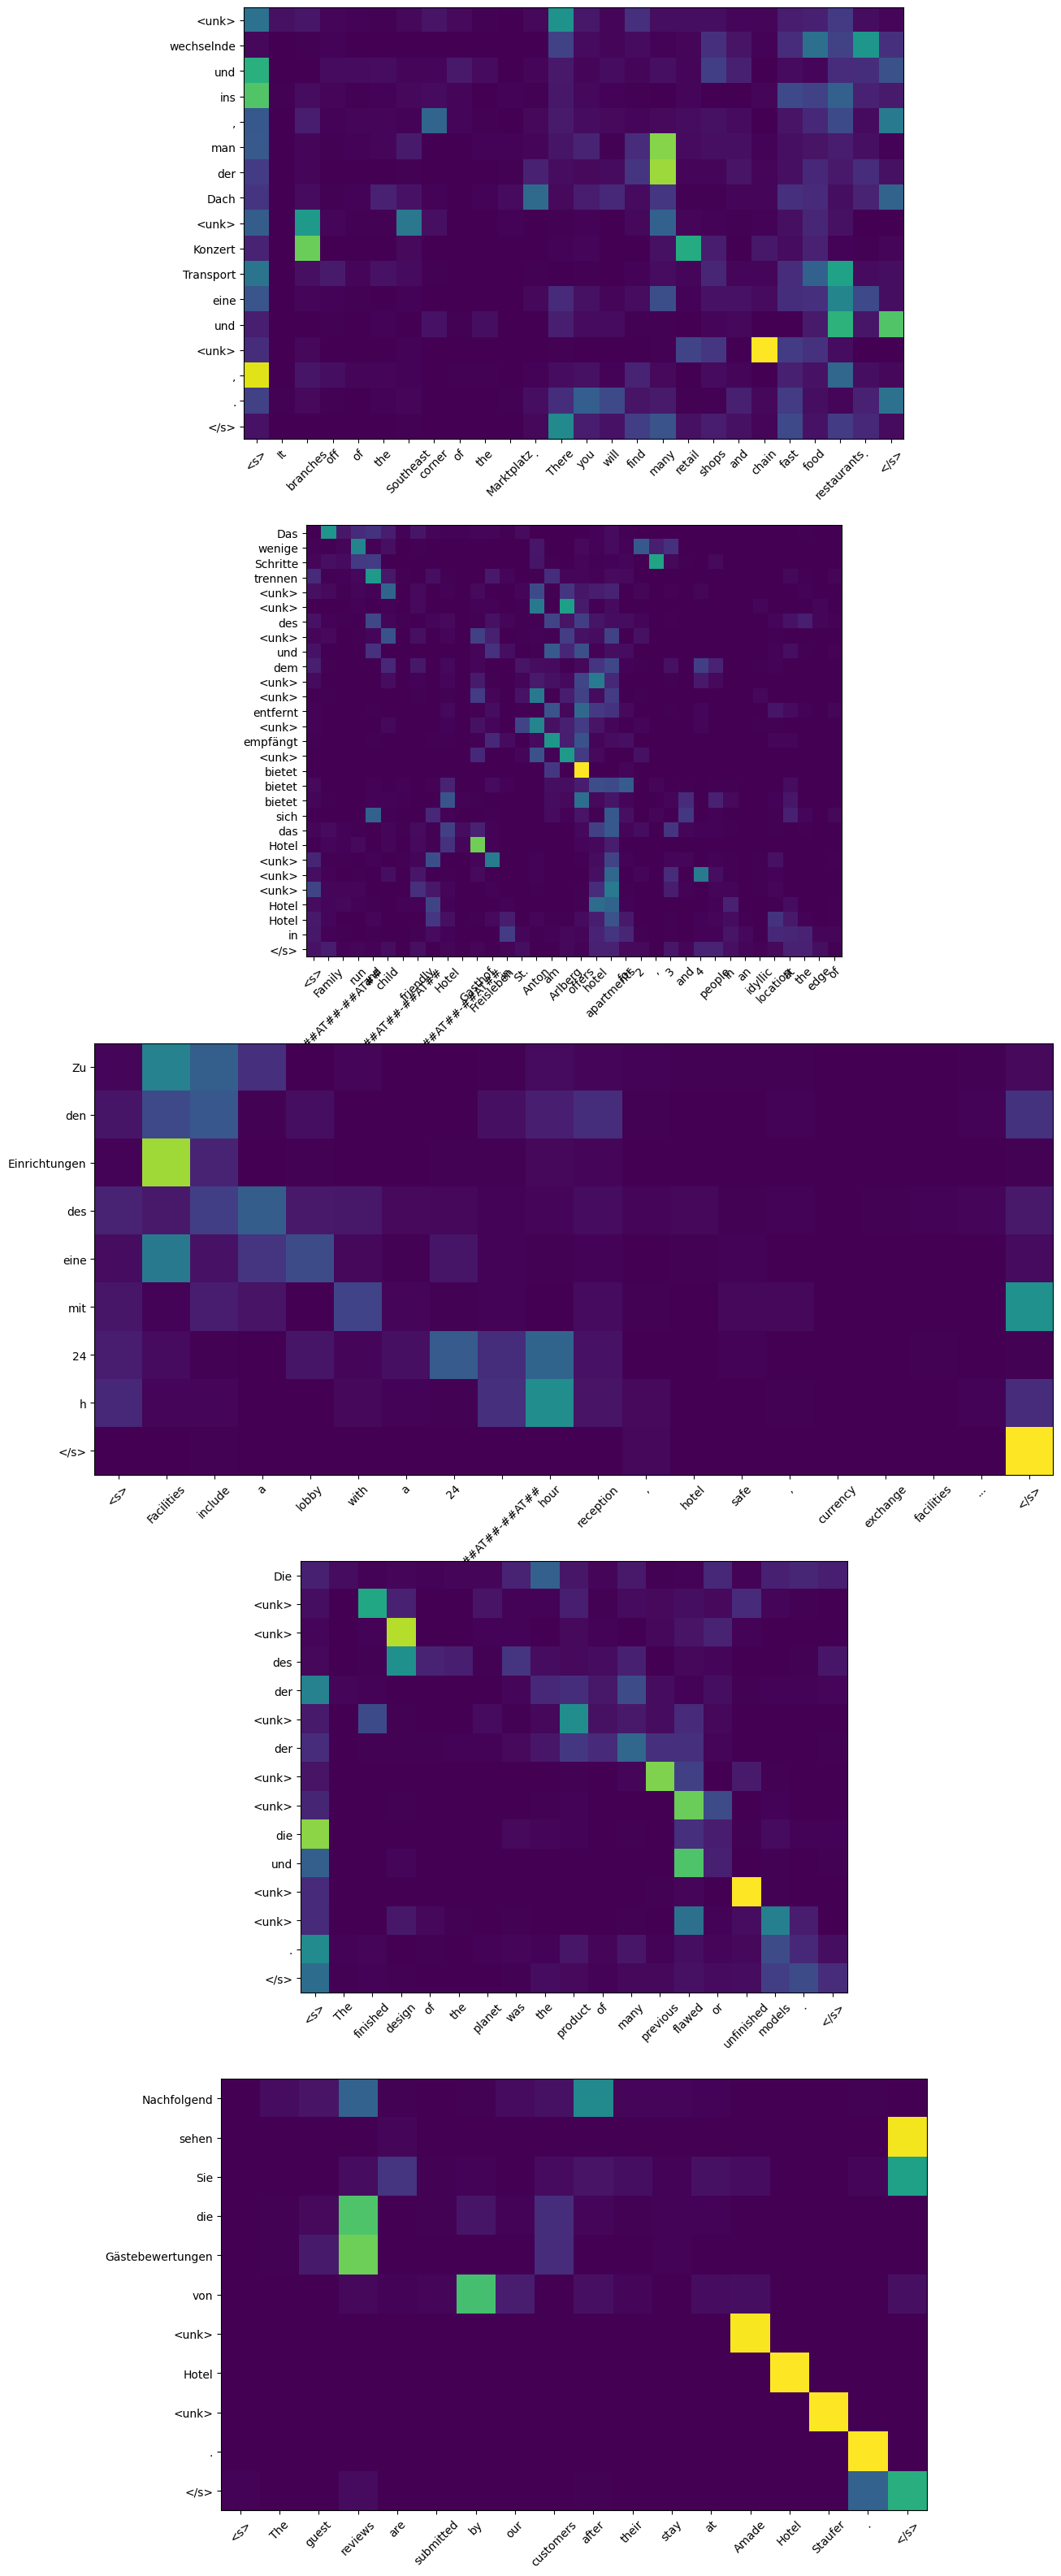

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

_, axes = plt.subplots(5, 1, figsize=(24,40))

attention_results = get_attention_matrix_for_sampled_data(
    attention_visualizer, 
    de_lookup_layer, 
    (test_en_sentences_padded, test_de_sentences_padded),
    n_samples = 5
)

for ax, result in zip(axes, attention_results):
    
    ax.imshow(result["attention_weights"])
    x_labels = result["input_words"]
    y_labels = result["predicted_words"]
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_yticklabels(y_labels, rotation=0)


## Inference with NMT

### $\rightarrow$ Inferencing is slightly different from the training process for NMT:

- As we do not have a target sentence at the inference time, we need a way to trigger the decoder at the end of the encoding phase. It’s not difficult as we have already done the groundwork for this in the data we have. 

    1. We simply kick off the decoder by using `<s>` as the first input to the decoder. Then we recursively call the decoder using the predicted word as the input for the next timestep. 

    2. We continue this way until the model:
        - Outputs `</s>` as the predicted token or
        - Reaches a pre-defined sentence length<br></br>

* **

### $\rightarrow$ Defining Inference Model

- To do this, we have to define a new model using the existing weights of the training model. 
    - This is because our trained model is designed to consume a sequence of decoder inputs at once. We need a mechanism to recursively call the decoder.<br></br>

- Here's how we can define the inference model:
    1. Define an encoder model that outputs the encoder’s hidden state sequence and the last encoder state.

    2. Define a new decoder that takes a decoder input having a time dimension of 1 and a new input, to which we will input the previous hidden state value of the decoder (initialized with the encoder’s last state).

* **

### $\rightarrow$ Generating Predictions


- With that, we can start feeding data to generate predictions as follows:
    - Preprocess $x_s$ as in data processing
    
    - Feed $x_s$ into ${GRU}_{enc}$ and calculate the encoder’s state sequence and the last state $h$ conditioned on$x_s$
    
    - Initialize ${GRU}_{dec}$ with $h$
    
    - For the initial prediction step, predict $\hat{Y}_{T}^{\text{2}}$ by conditioning the prediction on $\hat{Y}_{T}^{1} = \text{<s>}$ as the first word and $h$
    
    - For subsequent time steps, while $\hat{Y}_T^{i} \neq \text{</s>}$ and predictions haven't reached a pre-defined length threshold, predict $\hat{Y}_{T}^{m+1}$ by conditioning the prediction on $\left\{\hat{Y}_{T}^{m}, \hat{Y}_{T}^{m-1}, \ldots, \text{<s>}\right\}$ and $h$


This produces the translation given an input sequence of text:
<div align='center'>
    <img src='images/nmt_infer.png'/>
</div>

In [36]:
# Defining the encoder layers
encoder_input = tf.keras.layers.Input(shape=(n_en_seq_length,), dtype=tf.string)
# Converting tokens to IDs
en_lookup_layer = seq2seq_model.get_layer("string_lookup")
encoder_wid_out = en_lookup_layer(encoder_input)

# Embedding layer and lookup
en_emb_layer = seq2seq_model.get_layer("embedding")
encoder_emb_out = en_emb_layer(encoder_wid_out)

# Encoder GRU layer
en_gru_layer = seq2seq_model.get_layer("gru")
encoder_gru_out, encoder_gru_last_state = en_gru_layer(encoder_emb_out)

# Defining the encoder model: in - encoder_input / out - output of the GRU layer
encoder_model = tf.keras.models.Model(inputs=encoder_input, outputs=[encoder_gru_out, encoder_gru_last_state])

# Defining the decoder layers 
decoder_input = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
decoder_init_state_input = tf.keras.layers.Input(shape=(256,))
encoder_state_input = tf.keras.layers.Input(shape=(n_en_seq_length,256))
encoder_input_mask = tf.keras.layers.Input(shape=(n_en_seq_length,), dtype=tf.bool)

# Converting tokens to IDs (Decoder)
de_lookup_layer = seq2seq_model.get_layer("string_lookup_1")
decoder_wid_out = de_lookup_layer(decoder_input)

# Embedding layer and lookup (decoder)
de_emb_layer = seq2seq_model.get_layer("embedding_1")
decoder_emb_out = de_emb_layer(decoder_wid_out)

de_gru_layer = tf.keras.layers.GRU(256, return_sequences=True)
decoder_gru_out = de_gru_layer(decoder_emb_out, initial_state=decoder_init_state_input)

# The attention mechanism (inputs: [q, v, k])
attention_layer = seq2seq_model.get_layer("bahdanau_attention")
decoder_attn_out, attn_weights = attention_layer(
    query=decoder_gru_out, key=encoder_state_input, value=encoder_state_input,
    mask=encoder_input_mask,
    return_attention_scores=True
)

# Concatenate GRU output and the attention output
context_and_rnn_output = tf.keras.layers.Concatenate(axis=-1)([decoder_attn_out, decoder_gru_out])

# Final prediction layer (size of the vocabulary)
de_dense_layer = seq2seq_model.get_layer("dense_2")
decoder_out = de_dense_layer(context_and_rnn_output)

# Final seq2seq model
decoder_model = tf.keras.models.Model(
    inputs=[decoder_input, decoder_init_state_input, encoder_state_input, encoder_input_mask], 
    outputs=[decoder_out, decoder_gru_out]
)

decoder_model.compile()
de_gru_layer.set_weights(seq2seq_model.get_layer("gru_1").get_weights())

## Generating new translation

In [42]:
def generate_translation(en_sentence, en_lookup_layer, encoder_model, de_lookup_layer, decoder_model):
    
    de_vocabulary = de_lookup_layer.get_vocabulary()
    en_out, de_gru_state = encoder_model(en_sentence)
    
    y_pred = np.array([["<s>"]])
    predicted_sentence = [y_pred[0][0]]
    
    for _ in range(100):
        
        if y_pred == "</s>":
            break
            
        y_pred_probs, de_gru_state = decoder_model.predict([y_pred, de_gru_state, en_out, (en_sentence != pad_token)],
                                                           verbose=0)
        de_gru_state = de_gru_state[:, 0, :]
        y_pred_wid = np.argmax(y_pred_probs, axis=-1).ravel()[0]
        y_pred = np.array([[de_vocabulary[y_pred_wid]]])
        predicted_sentence.append(y_pred[0][0])
    
    return ' '.join(predicted_sentence)


for en_sentence, de_sentence in zip(test_en_sentences_padded[5:11,:], test_de_sentences_padded[5:11,:]):
    
    en_sentence_string = ' '.join([en_word for en_word in en_sentence if en_word != pad_token])
    print(f"EN: {en_sentence_string}\n")
    de_sentence_string = ' '.join([de_word for de_word in de_sentence if de_word != pad_token])
    print(f"DE (true): {de_sentence_string}\n")
    
    de_predicted = generate_translation(
        en_sentence.reshape(1, -1), en_lookup_layer, encoder_model, de_lookup_layer, decoder_model
    )
    print(f"DE (predicted): {de_predicted}\n")
    print("**"*50, '\n')

EN: <s> At night the many new and stylish bars and pubs attract guests for refreshing drinks or for enjoying a wide spectrum of music . </s>

DE (true): <s> In der Weltstadt Budapest servieren Restaurants Gaumenfreuden aus aller Herren Länder , dazu gehört auch die schmackhafte und scharfgewürzte ungarische Küche . </s>

DE (predicted): <s> In der Nacht servieren wir Ihnen auch bei der vielen neuen und stilvollen Bars sowie <unk> Getränke oder <unk> Getränke oder für die unterschiedlichsten Behandlungen . </s>

****************************************************************************************************
EN: <s> very expensive food &amp; drink , that &apos;s Norway for you I suppose ! </s>

DE (true): <s> The booking was not on their system on our arrival , during one of our nights we were kept awake with someone repeatedly trying to access our room and kicking the door

DE (predicted): <s> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 